#Conectamos a google drive e importamos librerias

In [ ]:
# Se conecta al Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle #para guardado de datos
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Conv2D, AveragePooling2D, BatchNormalization, Dropout, MaxPooling2D,RandomFlip,RandomRotation,MaxPool2D
from keras.applications.vgg16 import VGG16

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Para importar el Helper
%cd "/content/drive/Shareddrives/Redes neuronales/TP3"
!pip install import-ipynb
import import_ipynb
from Helper import *

/content/drive/Shareddrives/Redes neuronales/TP3
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=49e01aa90e4cf61f4f7f192d5f4c11221527a8397975b86b9a051fec5337df32
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb
importing Jupyter notebook from Helper.ipynb
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                

# Cargamos los datos

In [ ]:
X_train = np.load("/content/drive/Shareddrives/Redes neuronales/TP3/Dataset original/X_train.npy")
Y_train = np.load("/content/drive/Shareddrives/Redes neuronales/TP3/Dataset original/y_train.npy")
X_test = np.load("/content/drive/Shareddrives/Redes neuronales/TP3/Dataset original/X_test.npy")

# Dividimos entre datasets de entrenamiento y validación

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.1)

# Paso a float, normalizamos y categorizamos

In [ ]:
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = X_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255

In [ ]:
y_train_categorical = to_categorical(y_train,100)
y_val_categorical = to_categorical(y_valid,100)

# Data Augmentation: 

Se crean capas de preprocesamiento con Keras y se las aplica a las imágenes haciendoles transformaciones geométricas. Se agregan estas imágenes transformadas al conjunto de entrenamiento aumentandolo.

In [ ]:
x_train_pp,y_train_pp = data_augmentation(x_train,y_train_categorical,random_flip=True,mode_flip='horizontal',random_rotation=False)

# Creación y entrenamiento del modelo de transfer learning






##Se instancia el modelo VGG16 y se cargan pesos pre entrenados con imagenet

In [ ]:
preproc=VGG16(include_top = False, pooling = None, weights="imagenet",input_shape=(32,32,3))
preproc.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

##Se congelan todas las capas en el modelo base configurando trainable= False

In [ ]:
for layer in preproc.layers:
    layer.trainable=False

## Extacción de características: se corre el conjunto de datos por el modelo y se guardan las salidas del modelo base.

In [ ]:
x_pre_train=preproc.predict(x_train_pp)
x_pre_valid=preproc.predict(x_valid)

In [ ]:
x_pre_train[0].shape

(1, 1, 512)

##Se crea un nuevo modelo

In [ ]:
input_preproc=Input(shape=(1,1,512))

net=Flatten()(input_preproc)

net=Dense(units=256, activation='relu')(net)
net=Dropout(0.2)(net)
net=Dense(units=256, activation='relu')(net)
net=Dropout(0.2)(net)
net=Dense(units=100, activation = 'softmax')(net)

model=Model(input_preproc,net)

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               2570

## Se entrena el nuevo modelo con el output de modelo preentrenado

In [ ]:
# Callbacks
checkpoint_file =f"/content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/transfer_learning_dataaug_tere_2.hdf5"

earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=2)
checkpointer = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_file, verbose=1, save_best_only=True)

In [ ]:
batch_size = 64
epocs = 100

history = model.fit(x_pre_train, 
        y_train_pp,
        epochs=epocs, batch_size=batch_size, 
        verbose=1, 
        validation_data = (x_pre_valid, y_val_categorical),
        callbacks=[checkpointer, earlystop],
    )

Epoch 1/100
1400/1407 [============================>.] - ETA: 0s - loss: 4.4413 - accuracy: 0.0450
Epoch 00001: val_accuracy improved from -inf to 0.11840, saving model to /content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/transfer_learning_dataaug_tere_2.hdf5
1407/1407 [==============================] - 7s 5ms/step - loss: 4.4400 - accuracy: 0.0452 - val_loss: 4.0815 - val_accuracy: 0.1184
Epoch 2/100
1401/1407 [============================>.] - ETA: 0s - loss: 3.9165 - accuracy: 0.1044
Epoch 00002: val_accuracy improved from 0.11840 to 0.17160, saving model to /content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/transfer_learning_dataaug_tere_2.hdf5
1407/1407 [==============================] - 6s 5ms/step - loss: 3.9157 - accuracy: 0.1045 - val_loss: 3.5843 - val_accuracy: 0.1716
Epoch 3/100
1399/1407 [============================>.] - ETA: 0s - loss: 3.5998 - accuracy: 0.1447
Epoch 00003: val_accuracy improved from 0.17160 to 0.19780, saving model to 

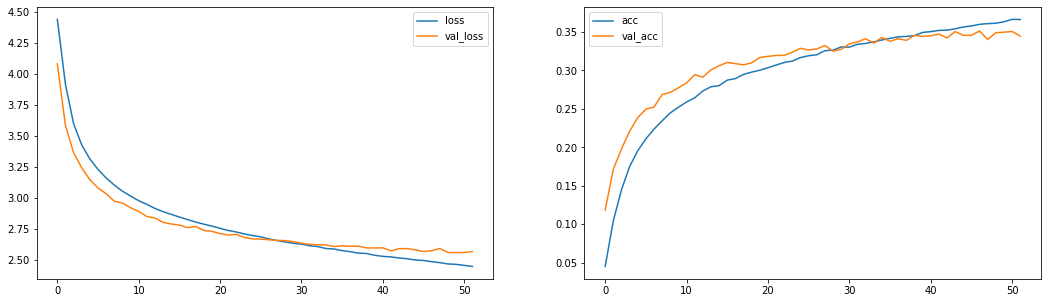

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18,5))
ax1.plot(history.history['loss'], label="loss")
ax1.plot(history.history['val_loss'], label="val_loss")
ax1.legend()

ax2.plot(history.history['accuracy'], label="acc")
ax2.plot(history.history['val_accuracy'], label="val_acc")
ax2.legend()
plt.show();

##Fine-tuning:

Este paso es opcional, en este caso se hace, para obtener mejoras a pesar de que puede conducir a un sobreajuste rápido. En Fine tunning, se descongela parte o todo el modelo base y se vuelve a entrenar tood el modelo de principio a fin con una tasa de aprendizaje muy baja.

In [ ]:
model.load_weights(checkpoint_file)

In [ ]:
total_model_output=model(preproc.output)
total_model=Model(preproc.input,total_model_output)
total_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

###Se descongela parte del modelo base

In [ ]:
for layer in preproc.layers:
    layer.trainable=True
total_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

###Se vuelve a entrenar todo el modelo de principio a fin




In [ ]:
total_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
# Callbacks
checkpoint_file='/content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/cifar10-cnn-TL-VGG16_fine_tunning_tere_rotation__tere_2.hdf5'
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=2)
checkpointer = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_file, verbose=1, save_best_only=True)

In [ ]:
batch_size = 64
epocs = 100

history = total_model.fit(x_train_pp, 
        y_train_pp,
        epochs=epocs, batch_size=batch_size, 
        verbose=1, 
        validation_data = (x_valid, y_val_categorical),
        callbacks=[checkpointer, earlystop],
    )

Epoch 1/100
1407/1407 [==============================] - ETA: 0s - loss: 2.5944 - accuracy: 0.3378
Epoch 00001: val_accuracy improved from -inf to 0.36560, saving model to /content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/cifar10-cnn-TL-VGG16_fine_tunning_tere_rotation__tere_2.hdf5
1407/1407 [==============================] - 113s 78ms/step - loss: 2.5944 - accuracy: 0.3378 - val_loss: 2.4543 - val_accuracy: 0.3656
Epoch 2/100
1407/1407 [==============================] - ETA: 0s - loss: 1.7597 - accuracy: 0.5132
Epoch 00002: val_accuracy improved from 0.36560 to 0.41280, saving model to /content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/cifar10-cnn-TL-VGG16_fine_tunning_tere_rotation__tere_2.hdf5
1407/1407 [==============================] - 109s 78ms/step - loss: 1.7597 - accuracy: 0.5132 - val_loss: 2.3065 - val_accuracy: 0.4128
Epoch 3/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.4324 - accuracy: 0.5902
Epoch 00003: val_accurac

# Resultados y conclusiones

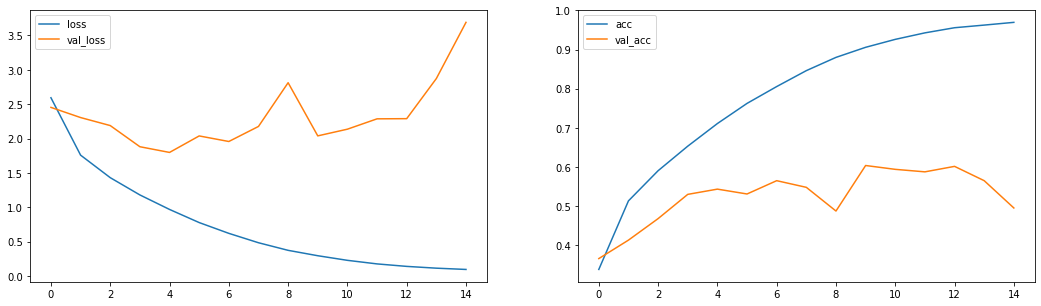

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18,5))
ax1.plot(history.history['loss'], label="loss")
ax1.plot(history.history['val_loss'], label="val_loss")
ax1.legend()

ax2.plot(history.history['accuracy'], label="acc")
ax2.plot(history.history['val_accuracy'], label="val_acc")
ax2.legend()
plt.show();

Se ve como a pesar de que los resultados mejoran notablemente comparado a los otros modelos que no utilizan transfer learning, pero también se produce overfitting. 

Además, se ve que a pesar que con data augmentation, se mejoró el accuracy del modelo, también se condujo a mayor sobreajuste probablemente debido a que las imágenes transformadas que se agregaron al dataset de entrenamiento, no eran tan distintas a las originales lo que también pudo conducir a un mayor sobreajuste del modelo. 

# Predicción de clases y submission

In [ ]:
path_results = "/content/drive/Shareddrives/Redes neuronales/TP3/Submissions/sumbission_cnn-TL-VGG16_fine_tunning_tere_rotation__tere_1.csv"
path_model = checkpoint_file
results = predic(x_test,path_results,total_model,path_model)
results

,label
Id,
0,79
1,38
2,30
3,91
4,71
...,...
9995,83
9996,14
9997,51
